Trying to figure out a full 0->1 pipeline for recognising protons/deuterons from the RAW data, and just selecting that data and getting final proton + deuterons data to work on for physical seperation.

First, first step I think is to be able to automate the answer to this question: Is there a proton or a deuteron in the event?

In [1]:
import sys
sys.path.append('..')

In [2]:
import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [3]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
protons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/protons_one_track_filepaths.csv') # with only one track from reco

In [4]:
protons.columns, deuterons.columns, protons.shape, deuterons.shape

(Index(['run', 'subrun', 'event', 'file_path', 'filename', 'event_index'], dtype='object'),
 Index(['run', 'subrun', 'event', 'file_path', 'event_index', 'col_max_adc',
        'ind_max_adc', 'col_activity_pixels', 'ind_activity_pixels'],
       dtype='object'),
 (7636, 6),
 (6961, 9))

In [45]:
n = 3223
eventp = Event(protons.file_path[n], index=protons.event_index[n])
eventd = Event(deuterons.file_path[n], index=deuterons.event_index[n])


Found 13 connected regions
Found 5 connected regions
Found 12 connected regions
Found 13 connected regions


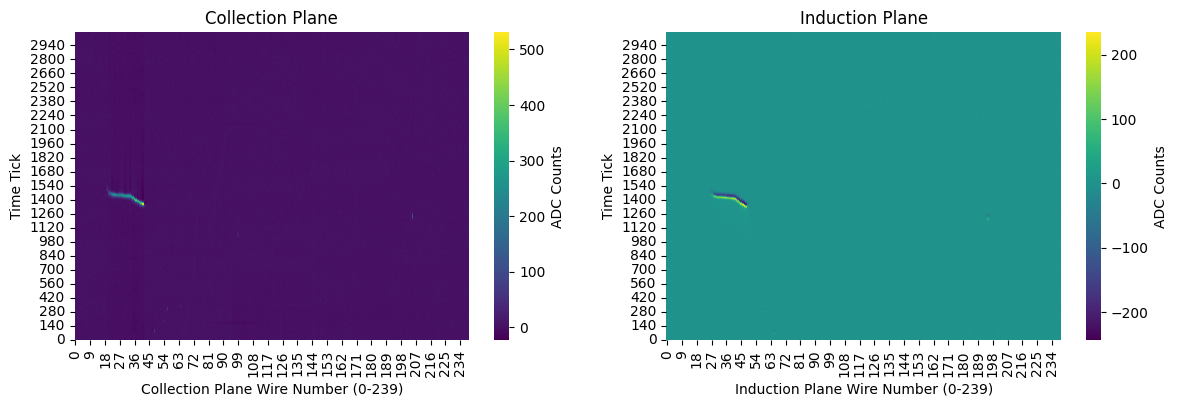

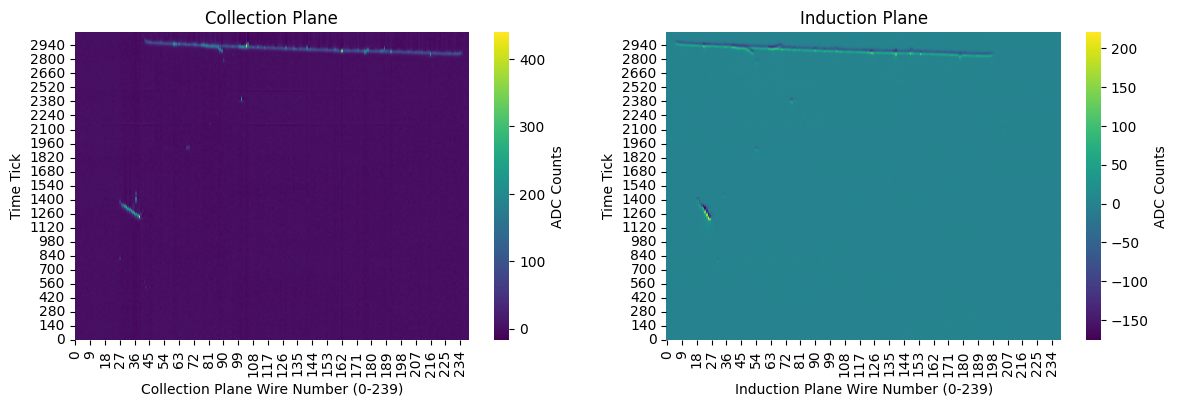

In [46]:
eventp.plot()
eventd.plot()

Found 12 connected regions


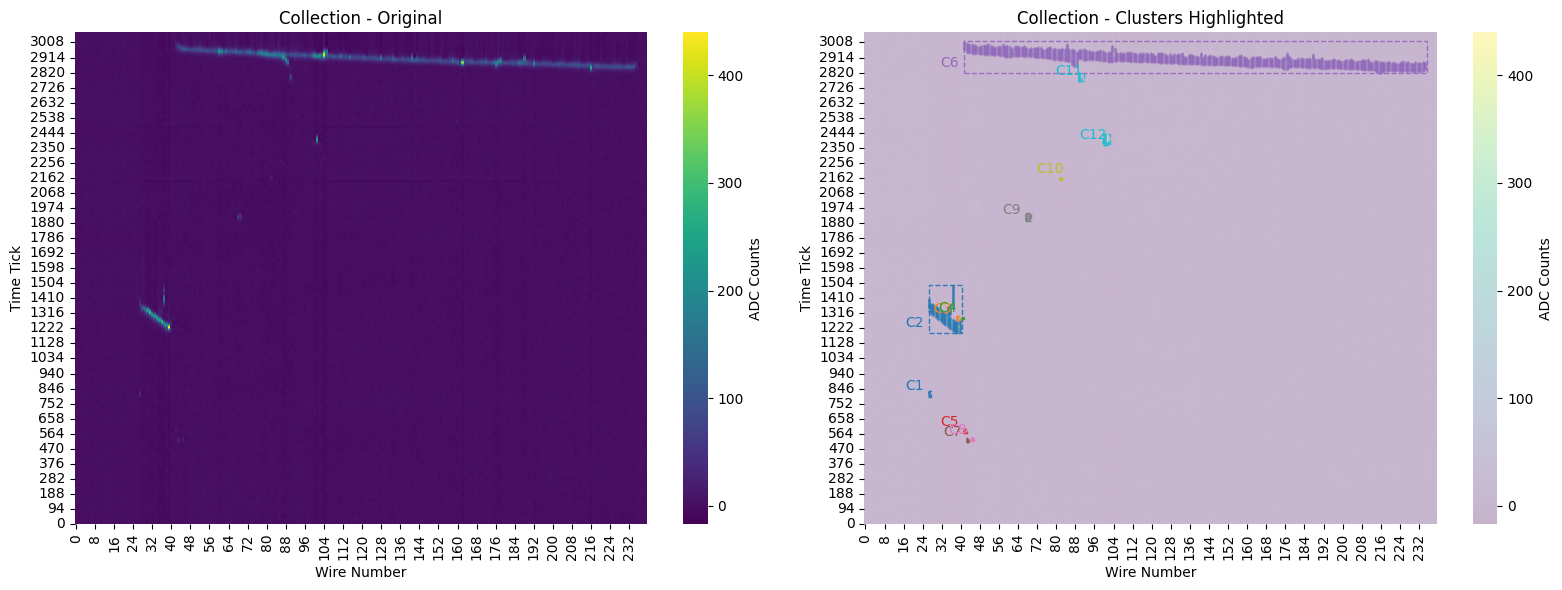

In [47]:
l, r = eventd.clustering()

In [53]:
c = eventd.connectedcr[5].image_intensity

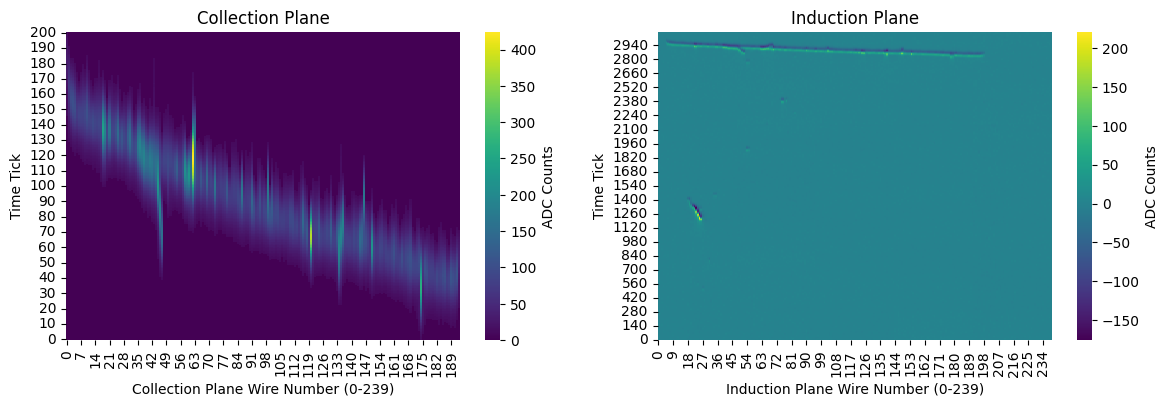

In [54]:
eventd.plot(c)

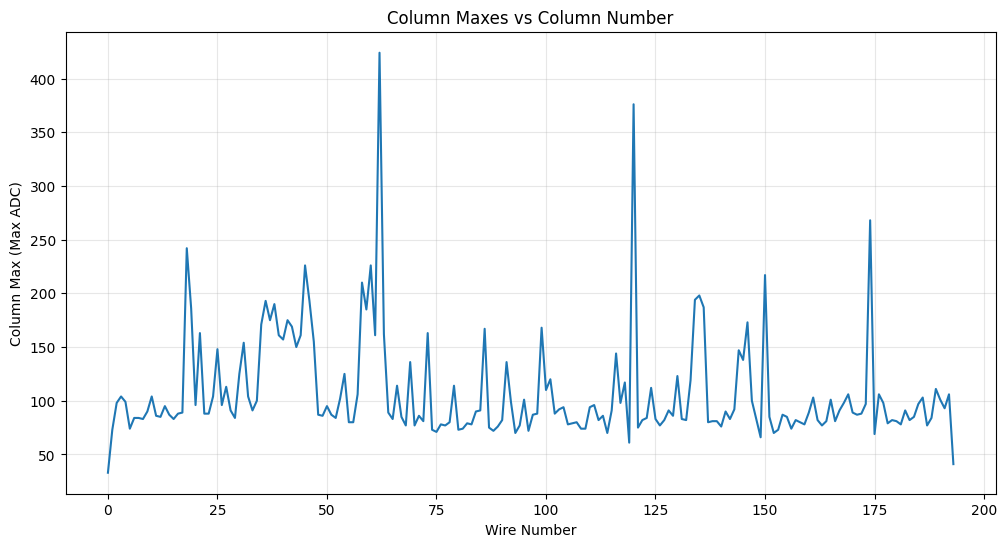

Matrix shape: (201, 194)
Number of columns: 194
Max column max: 424.0 at column 62
Min column max: 33.0 at column 0


In [55]:
# Get the matrix
matrix = c
matrix = matrix.T
matrix = matrix[::-1]

# Get max of each column (axis=0 finds max along rows, giving column maxes)
column_maxes = np.max(matrix, axis=0)

# Plot column maxes vs column number
plt.figure(figsize=(12, 6))
plt.plot(column_maxes)
plt.xlabel('Wire Number')
plt.ylabel('Column Max (Max ADC)')
plt.title('Column Maxes vs Column Number')
plt.grid(True, alpha=0.3)
plt.show()

# Print some stats
print(f"Matrix shape: {matrix.shape}")
print(f"Number of columns: {len(column_maxes)}")
print(f"Max column max: {column_maxes.max():.1f} at column {column_maxes.argmax()}")
print(f"Min column max: {column_maxes.min():.1f} at column {column_maxes.argmin()}")

In [56]:
column_maxes

array([ 33.,  73.,  98., 104.,  99.,  74.,  84.,  84.,  83.,  90., 104.,
        86.,  85.,  95.,  87.,  83.,  88.,  89., 242., 186.,  96., 163.,
        88.,  88., 104., 148.,  96., 113.,  91.,  84., 125., 154., 104.,
        91., 100., 171., 193., 175., 190., 161., 157., 175., 169., 150.,
       161., 226., 193., 155.,  87.,  86.,  95.,  87.,  84., 102., 125.,
        80.,  80., 106., 210., 185., 226., 161., 424., 162.,  89.,  83.,
       114.,  85.,  77., 136.,  77.,  86.,  81., 163.,  73.,  71.,  78.,
        77.,  80., 114.,  73.,  74.,  79.,  78.,  90.,  91., 167.,  75.,
        72.,  76.,  82., 136.,  99.,  70.,  77., 101.,  72.,  87.,  88.,
       168., 110., 120.,  88.,  92.,  94.,  78.,  79.,  80.,  74.,  74.,
        94.,  96.,  82.,  86.,  70.,  91., 144.,  98., 117.,  61., 376.,
        75.,  82.,  84., 112.,  83.,  77.,  82.,  91.,  86., 123.,  83.,
        82., 119., 194., 198., 187.,  80.,  81.,  81.,  76.,  90.,  83.,
        92., 147., 138., 173., 100.,  83.,  66., 21

In [57]:
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(matrix)

[[ 11.   0.  -0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.  -0.   0.  -0.   0.  -0.  -0.  -0.  -0.   0.   0.   0.  -0.   0.   0.  -0.  -0.   0.  -0.   0.   0.  -0.   0.   0.   0.  -0.   0.   0.   0.   0.  -0.   0.  -0.  -0.   0.  -0.   0.   0.   0.   0.   0.  -0.  -0.  -0.   0.   0.  -0.  -0.  -0.  -0.   0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   0.   0.   0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   0.  -0.  -0.   0.  -0.   0.  -0.   0.  -0.  -0.  -0.   0.   0.  -0.   0.  -0.   0.  -0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.  -0.  -0.  -0.   0.  -0.   0.  -0.  -0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.  -0.  -0.  -0.   0.  -0.  -0.   0.   0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   0.  -0.   0.   0.  -0.  -0.  -0.   0.  -0.   0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   0.  -0.   0.   0.  -0.  -0.   0.  -0.   0.  -0.  -0.  -0.  -0.]
 [ 13.   0.  -0.   0.   0. 

random